## Income Risks Estimation 

This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average process of income/earnings
 - It allows for different assumptions about expectations, ranging from rational expectation to alternative assumptions. 

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import copy as cp

In [506]:
## class of integrated moving average process, trend/cycle process allowing for serial correlation transitory shocks
class IMAProcess:
    '''
    inputs
    ------
    t: int, number of periods of the series
    process_para, dict, includes 
       - ma_coeffs: size f q for MA(q),  moving average coeffcients of transitory shocks. q = 0 by default.
       - sigmas:  size of t x 2, draws of permanent and transitory risks from time varying volatility 
    '''
    def __init__(self,
                 t = 100,
                 n_periods = 1,
                 process_para = {'ma_coeffs':np.ones(0),
                                 'sigmas': np.ones((2,100))}
                ):
        self.process_para = process_para
        self.ma_coeffs = process_para['ma_coeffs']
        self.ma_q = len(process_para)
        self.t = t
        self.sigmas = process_para['sigmas']
        self.n_periods = n_periods
    
    ## auxiliary function for ma cum sum
    def cumshocks(self,
                  shocks,
                  ma_coeffs):
        cum = []
        for i in range(len(shocks)):
            #print(shocks[i])
            #print(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
            cum.append(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
        return np.array(cum)         
    
    def SimulateSeries(self,
                      n_sim = 100):
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        ma_q = self.ma_q 
                 
        p_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  # draw permanent shocks
        t_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[1,:],[n_sim,1]))  ## draw one-period transitory shocks 
        t_draws_cum = np.array( [self.cumshocks(shocks = t_draws[i,:],
                                                ma_coeffs = ma_coeffs) 
                                 for i in range(n_sim)]
                              )
        series = np.cumsum(p_draws,axis = 1) + t_draws_cum 
        self.simulated = series
        return self.simulated 
       
    def SimulatedMoments(self):
        series = self.simulated 
        
        ## the first difference 
        diff = np.diff(series,axis=1)
        
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.SimMoms
    
    def TimeAggregate(self,
                      n_periods = None):
        simulated = self.simulated
        t = self.t
        n_periods = self.n_periods
        
        simulated_agg = np.array([np.sum(simulated[:,i-n_periods:i],axis=1) for i in range(n_periods,t+1)]).T
        self.simulated_agg = simulated_agg
        return self.simulated_agg
    
    def SimulateMomentsAgg(self):
        series_agg = self.simulated_agg 
        
        ## the first difference 
        diff = np.diff(series_agg,
                       axis=1)
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimAggMoms = {'Mean':mean_diff,
                           'Var':varcov_diff}
        return self.SimAggMoms
    
    def ComputeGenMoments(self):
        ## parameters 
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        p_sigmas = sigmas[0,:]
        t_sigmas = sigmas[1,:]
        ma_q = self.ma_q 
        
        ## generalized moments 
        mean_diff = np.zeros(t) 
        ## varcov is basically the variance covariance of first difference of income of this IMA(q) process
        ## Cov(delta y_t - delta y_{t+k}) forall k for all t
        varcov_diff = np.asmatrix( np.zeros(t**2).reshape([t,t]) )
        
        for i in range(t):
            autocovf_this = p_sigmas[i]**2 + t_sigmas[i]**2 + t_sigmas[i-1]**2
            varcov_diff[i,i] = autocovf_this
            try:
                varcov_diff[i,i+1] = - t_sigmas[i]**2
                varcov_diff[i+1,i] = - t_sigmas[i]**2            
            except:
                pass
        self.GenMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.GenMoms
    
    def GetDataMoments(self,
                      data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    def EstimatePara(self,
                         method = 'TNC',
                         options = {'disp':True}):
        data_moms_dct = self.data_moms_dct
        t = self.t
        
        def ObjFunc(self,
                    para_est = self.process_para):
            an_instance = self.__init__(t = t,
                                        process_para = {'ma_coeffs':para_est[0],
                                'sigmas':para_est[1]}
                                       )
            #a_sim = self.SimulateSeries()
            model_moms_dct = an_instance.ComputeGenMoments() 
            model_moms = np.array([model_moms_dct[key] for key in model_moms_dct.keys()])
            data_moms = np.array([data_moms_dct[key] for key in data_moms_dct.keys()])
            diff = np.linalg.norm(model_moms_dct - data_moms)
            return diff
        
        para_est = minimize(ObjFunc,
                           x0 = None,
                           method = method,
                           options = options)
        
        self.para_est = para_est
        return self.para_est    
        
    def EstimateParabySim(self,
                         method = 'TNC',
                         options = {'disp':True}):
        data_moms_dct = self.data_moms_dct
        process_para_default = self.process_para
        
        def ObjFunc(self,
                    para_est = process_para_default):
            self.process_para = {'ma_coeffs':para_est[0],
                                'sigmas':para_est[1]}
            a_sim = self.SimulateSeries()
            model_moms_sim_dct = self.SimulatedMoments() 
            model_moms = np.array([model_moms_sim_dct[key] for key in model_moms_sim_dct.keys()])
            data_moms = np.array([data_moms_dct[key] for key in data_moms_dct.keys()])
            diff = np.linalg.norm(model_moms_sim - data_moms)
            return diff
        
        para_est = minimize(ObjFunc,
                           x0 = None,
                           method = method,
                           options = options)
        
        self.para_est = para_est
        return self.para_est
    
    def Autocovar(self,
                  step = 1):
        cov_var = self.SimMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        return self.autovar
    
    def AutocovarComp(self,
                  step = 1):
        cov_var = self.GenMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovarGen = autovar
        return self.autovarGen
    
    def AutocovarAgg(self,
                     step = 0):
        cov_var = self.SimAggMoms['Var']
        if step >=0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)]) 
        if step < 0:
            autovar = np.array([cov_var[i,i+step] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        self.autovaragg = autovar
        return self.autovaragg 

In [507]:
## debugging test of the data 

t = 50
ma_nosa = np.ones(1)
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = np.random.uniform(0,1,t) ## allowing for time-variant shocks 

pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt = IMAProcess(t = t,
               process_para = {'ma_coeffs':ma_nosa,
                              'sigmas':sigmas})
sim_data = dt.SimulateSeries(n_sim = 5000)
sim_moms = dt.SimulatedMoments()

In [508]:
## get the computed moments 

comp_moms = dt.ComputeGenMoments()

av_comp = comp_moms['Mean']
cov_var_comp = comp_moms['Var']
var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 

In [509]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

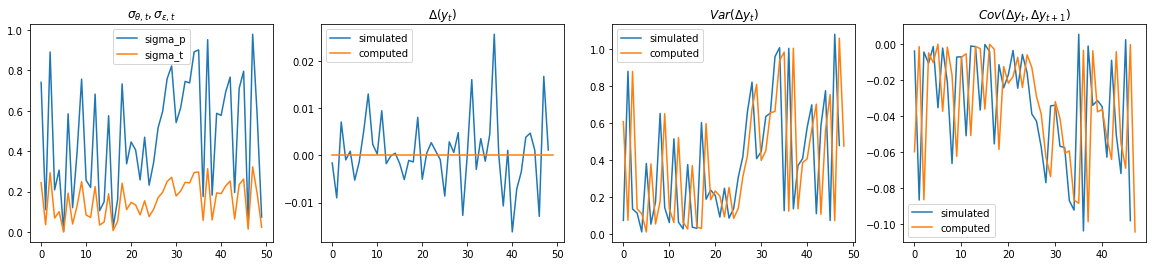

In [510]:
## plot simulated moments of first diff 

plt.figure(figsize=((20,4)))

plt.subplot(1,4,1)
plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
plt.plot(p_sigmas_draw,label='sigma_p')
plt.plot(t_sigmas,label='sigma_t')
plt.legend(loc=0)

plt.subplot(1,4,2)
plt.title(r'$\Delta(y_t)$')
plt.plot(av,label='simulated')
plt.plot(av_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,3)
plt.title(r'$Var(\Delta y_t)$')
plt.plot(var,label='simulated')
plt.plot(var_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,4)
plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
plt.plot(autovarb1,label='simulated')
plt.plot(autovarb1_comp,label='computed')
plt.legend(loc = 0)

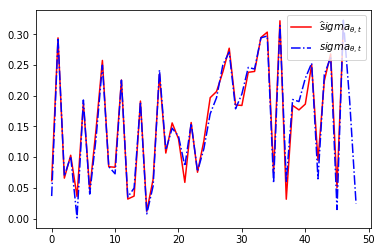

In [511]:
## robustness check if the transitory risks is approximately equal to the assigned level

sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
plt.plot(sigma_t_est,'r-',label=r'$\widehat sigma_{\theta,t}$')
plt.plot(t_sigmas[1:],'b-.',label=r'$sigma_{\theta,t}$')
plt.legend(loc=1)

In [512]:
## test of estimator by simulation 

sim_moms_fake = sim_moms.copy()
new_IMA = cp.deepcopy(dt)
new_IMA.GetDataMoments(sim_moms_fake)
#new_IMA.EstimatePara()

In [513]:
## time aggregation 

sim_data = dt.SimulateSeries(n_sim = 1000)
agg_series = dt.TimeAggregate(n_periods = 3)
agg_series_moms = dt.SimulateMomentsAgg()

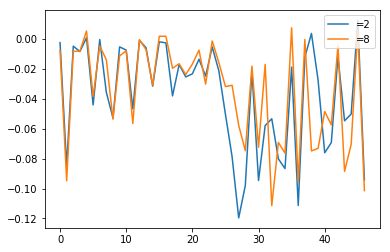

In [516]:
## difference times degree of time aggregation leads to different autocorrelation
for ns in np.array([2,8]):
    an_instance = cp.deepcopy(dt)
    series = an_instance.SimulateSeries(n_sim =500)
    agg_series = an_instance.TimeAggregate(n_periods = ns)
    agg_series_moms = an_instance.SimulateMomentsAgg()
    var_sim = an_instance.AutocovarAgg(step=0)
    var_b1 = an_instance.AutocovarAgg(step=-1)
    plt.plot(var_b1,label=r'={}'.format(ns))
plt.legend(loc=1)